## This file is for the penultimate development of this 4-Level Model

##### TRAINING SUBSECTION

In [1]:
'''NOTE Load in the training data for level-0 models'''

import _Data_Processing
import joblib
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X, X_train, X_val, X_ind,\
y, y_train, y_val, y_ind,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_large.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,keep_price =		False
    ,keep_time	=		True
	,optm_data	=		True
    ,indices	=		0
)
joblib.dump(scaler, 'scaler/tmp.joblib')

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 125400164 -> 64675164
loaded chunk 3 of size: 125400164 -> 64675164
loaded chunk 4 of size: 125400164 -> 64675164
loaded chunk 5 of size: 125400164 -> 64675164
loaded chunk 6 of size: 125400164 -> 64675164
loaded chunk 7 of size: 125400164 -> 64675164
loaded chunk 8 of size: 125400164 -> 64675164
loaded chunk 9 of size: 125400164 -> 64675164
loaded chunk 10 of size: 125400164 -> 64675164
loaded chunk 11 of size: 125400164 -> 64575164
loaded chunk 12 of size: 125400164 -> 64675164
loaded chunk 13 of size: 125400164 -> 64675164
loaded chunk 14 of size: 111646292 -> 57581610
concat chunks
concatted chunks
Success.
Size of dataset:	898356610
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success.
Trying to drop price features...
NOTE DROPPING real prices from dataset has been removed.Now prices are removed from feature subsection selection fo

['scaler/tmp.joblib']

In [2]:
'''NOTE Shred the data to run parallel to desired level-0 structure'''

import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
	,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.75
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	False
	,filter_type	=	'Retention'
	,filter_value	=	0.95
	,n_sample_parts	=	1
	,smpl_part_type	=	'Even'
	,sample_overlap	=	0.9
	,sample_shuffle	=	False
	,lstm_format	=	lstm_format
)

2025-02-10 18:32:24.276926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 18:32:24.290972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739230344.305471   76602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739230344.309633   76602 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 18:32:24.326066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Custom parameters selected.
nn	-	{'optimizer_type': 'Adam', 'optimizer_kwarg': {'learning_rate': 0.00025}, 'time_steps': 5, 'LSTM': False, 'shuffle_train': True, 'epochs': 7, 'rlr_patience': 20, 'architecture': 'default_deep'}
Running on: GPU



I0000 00:00:1739230345.954722   76602 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1962 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Training model #1
Running on: GPU

Epoch 1/7


I0000 00:00:1739230350.103734   76758 service.cc:148] XLA service 0x7f37800086b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739230350.103766   76758 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-02-10 18:32:30.184299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739230350.590482   76758 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/944 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4878 - loss: 0.8519 - precision: 0.4832 - recall: 0.4119

I0000 00:00:1739230354.207816   76758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


944/944 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4945 - loss: 0.8200 - precision: 0.5031 - recall: 0.4390 - val_accuracy: 0.4955 - val_loss: 0.6942 - val_precision: 0.5761 - val_recall: 0.2460 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4968 - loss: 0.7429 - precision: 0.5145 - recall: 0.4497 - val_accuracy: 0.4944 - val_loss: 0.7024 - val_precision: 0.5668 - val_recall: 0.2666 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5070 - loss: 0.7208 - precision: 0.5249 - recall: 0.4349 - val_accuracy: 0.4992 - val_loss: 0.6951 - val_precision: 0.5702 - val_recall: 0.2916 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4984 - loss: 0.7122 - precision: 0.5047 - recall: 0.4093 - val_accuracy: 0.5186 - val_loss: 0.6970 - val_precision: 0.5347 - val_recall: 0.8304 - learning_rate: 2.5000e-04
Epoch 5/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy

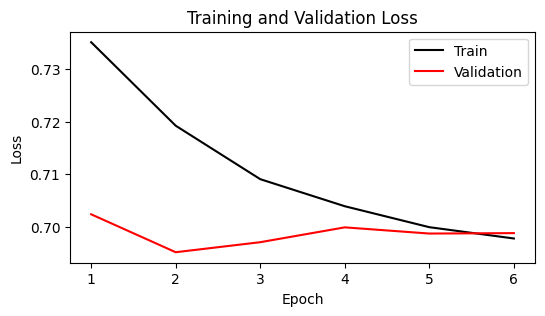

Running on: GPU

Training model #2
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5130 - loss: 0.7816 - precision: 0.5210 - recall: 0.4956 - val_accuracy: 0.4919 - val_loss: 0.7086 - val_precision: 0.5786 - val_recall: 0.2142 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5038 - loss: 0.7253 - precision: 0.5121 - recall: 0.4933 - val_accuracy: 0.5081 - val_loss: 0.6964 - val_precision: 0.6072 - val_recall: 0.2501 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5060 - loss: 0.7054 - precision: 0.5249 - recall: 0.5142 - val_accuracy: 0.4844 - val_loss: 0.6984 - val_precision: 0.5570 - val_recall: 0.2169 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5096 - loss: 0.6991 - precision: 0.5186 - recall: 0.4880 - val_accuracy: 0.4953 - val_loss: 0.6956 - val_precision: 0.5643 - val_recall: 0.2831 - learning_rate: 2.5000e-04

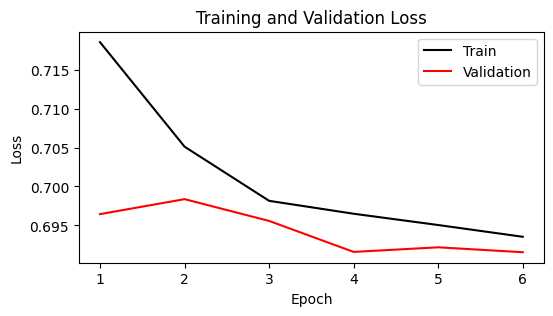

Running on: GPU

Training model #3
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5006 - loss: 0.8413 - precision: 0.5120 - recall: 0.5015 - val_accuracy: 0.5270 - val_loss: 0.6912 - val_precision: 0.5550 - val_recall: 0.6213 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5026 - loss: 0.7533 - precision: 0.5118 - recall: 0.4807 - val_accuracy: 0.5314 - val_loss: 0.6907 - val_precision: 0.5700 - val_recall: 0.5352 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4935 - loss: 0.7300 - precision: 0.5034 - recall: 0.4610 - val_accuracy: 0.5363 - val_loss: 0.6907 - val_precision: 0.5858 - val_recall: 0.4796 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4988 - loss: 0.7126 - precision: 0.5101 - recall: 0.4584 - val_accuracy: 0.5336 - val_loss: 0.6910 - val_precision: 0.5885 - val_recall: 0.4508 - learning_rate: 2.5000e-04

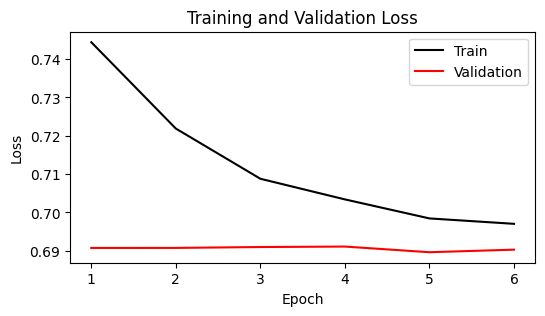

Running on: GPU

Training model #4
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5007 - loss: 0.7835 - precision: 0.5083 - recall: 0.5375 - val_accuracy: 0.5295 - val_loss: 0.6933 - val_precision: 0.5599 - val_recall: 0.5978 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5017 - loss: 0.7235 - precision: 0.5081 - recall: 0.5290 - val_accuracy: 0.5196 - val_loss: 0.6948 - val_precision: 0.5547 - val_recall: 0.5556 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5054 - loss: 0.7069 - precision: 0.5136 - recall: 0.5235 - val_accuracy: 0.5056 - val_loss: 0.6944 - val_precision: 0.5447 - val_recall: 0.5097 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5016 - loss: 0.7025 - precision: 0.5094 - recall: 0.5212 - val_accuracy: 0.5085 - val_loss: 0.6941 - val_precision: 0.5474 - val_recall: 0.5138 - learning_rate: 2.5000e-04

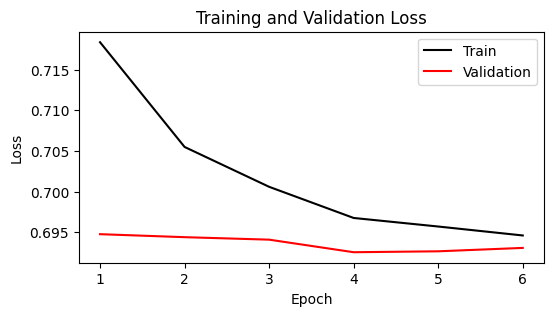

Running on: GPU

Training model #5
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5060 - loss: 0.8636 - precision: 0.5131 - recall: 0.5291 - val_accuracy: 0.5012 - val_loss: 0.7006 - val_precision: 0.5393 - val_recall: 0.5172 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5042 - loss: 0.7614 - precision: 0.5112 - recall: 0.5338 - val_accuracy: 0.4970 - val_loss: 0.7008 - val_precision: 0.5333 - val_recall: 0.5427 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4992 - loss: 0.7309 - precision: 0.5091 - recall: 0.5306 - val_accuracy: 0.4868 - val_loss: 0.6982 - val_precision: 0.5257 - val_recall: 0.4990 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5016 - loss: 0.7130 - precision: 0.5094 - recall: 0.5254 - val_accuracy: 0.4996 - val_loss: 0.6961 - val_precision: 0.5320 - val_recall: 0.6033 - learning_rate: 2.5000e-04

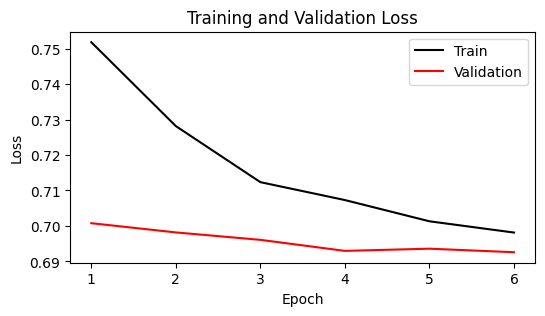

Running on: GPU

Training model #6
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4983 - loss: 0.8674 - precision: 0.5063 - recall: 0.4328 - val_accuracy: 0.5008 - val_loss: 0.7050 - val_precision: 0.5724 - val_recall: 0.2955 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5122 - loss: 0.7446 - precision: 0.5223 - recall: 0.4872 - val_accuracy: 0.4834 - val_loss: 0.7024 - val_precision: 0.5531 - val_recall: 0.2210 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4961 - loss: 0.7242 - precision: 0.5091 - recall: 0.4846 - val_accuracy: 0.4842 - val_loss: 0.6990 - val_precision: 0.5512 - val_recall: 0.2363 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5033 - loss: 0.7093 - precision: 0.5144 - recall: 0.4870 - val_accuracy: 0.4767 - val_loss: 0.6984 - val_precision: 0.5422 - val_recall: 0.1934 - learning_rate: 2.5000e-04

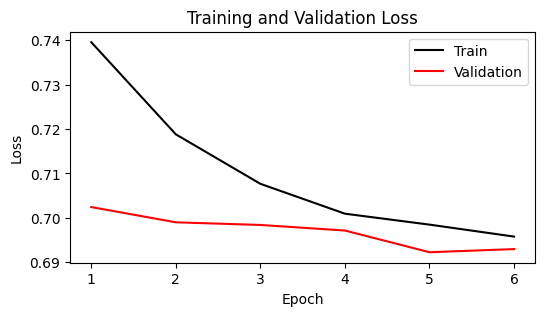

Running on: GPU

Training model #7
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5022 - loss: 0.9004 - precision: 0.5103 - recall: 0.4992 - val_accuracy: 0.5241 - val_loss: 0.7012 - val_precision: 0.5463 - val_recall: 0.6958 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5072 - loss: 0.7601 - precision: 0.5203 - recall: 0.4882 - val_accuracy: 0.5237 - val_loss: 0.6982 - val_precision: 0.5583 - val_recall: 0.5611 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5012 - loss: 0.7296 - precision: 0.5107 - recall: 0.4785 - val_accuracy: 0.5453 - val_loss: 0.6877 - val_precision: 0.5790 - val_recall: 0.5762 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5086 - loss: 0.7097 - precision: 0.5194 - recall: 0.4759 - val_accuracy: 0.5473 - val_loss: 0.6896 - val_precision: 0.5754 - val_recall: 0.6138 - learning_rate: 2.5000e-0

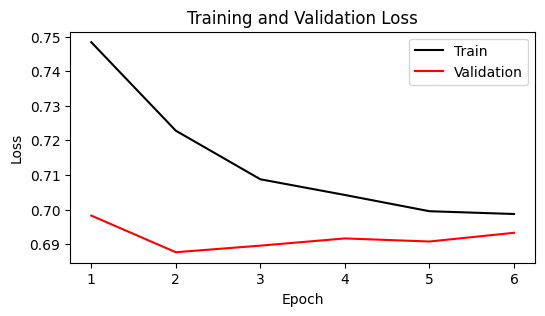

Running on: GPU

Training model #8
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5078 - loss: 0.9364 - precision: 0.5208 - recall: 0.4762 - val_accuracy: 0.4624 - val_loss: 0.7274 - val_precision: 0.5032 - val_recall: 0.2887 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5082 - loss: 0.7786 - precision: 0.5214 - recall: 0.5043 - val_accuracy: 0.4605 - val_loss: 0.7133 - val_precision: 0.5000 - val_recall: 0.3445 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4970 - loss: 0.7403 - precision: 0.5097 - recall: 0.5142 - val_accuracy: 0.4652 - val_loss: 0.7054 - val_precision: 0.5065 - val_recall: 0.3426 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5040 - loss: 0.7162 - precision: 0.5166 - recall: 0.5197 - val_accuracy: 0.4745 - val_loss: 0.7009 - val_precision: 0.5197 - val_recall: 0.3421 - learning_rate: 2.5000e-0

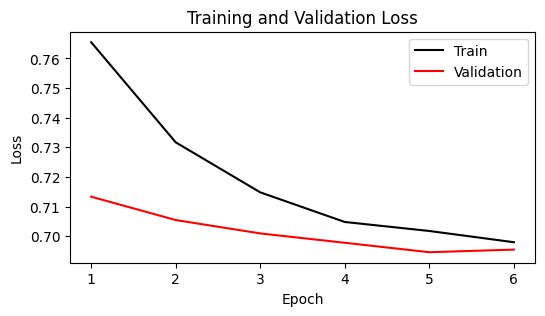

In [3]:
'''NOTE Begin training for each level-0 model'''

import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
	Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
	Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
	model_types	=	['nn']
	,data_parts	=	X_train_parts
	,findx_parts=	X_find_parts
	,trans_parts=	X_trans_parts
	,trgt_parts	=	y_parts
	,X_valid	=	X_val
	,y_valid	=	y_val
	,param_mode	=	'custom'
	,cst_mod_prm=	[{
		'optimizer_type'	:	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.00025
			#,'momentum'		:	0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	7
		,'rlr_patience'		:	20
		,'architecture'	:	'default_deep'
		#,'external_cw'	:	_Utility.get_class_weights(y_train)
		}]
	,tnr_verbose=	True
	,lstm_frmt	=	lstm_format
	,use_cls_wt	=	True
)

In [4]:
'''NOTE show performances of level-0 Models'''

import _Model_Evaluation
import _Neural_Net

reload(_Model_Evaluation)
reload(_Neural_Net)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
		,lstm_frmt	=	lstm_format
)

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Dimensions of Trained Models:
	Feature Space: 8
	Sample Space: 1
	Model Space: 1


	Displaying all performances for all independent samples: (8 cases)

4

Statistics Overall:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.02	0.5	0.55
		Precision	0.57	0.03	0.53	0.61
		Recall		0.53	0.18	0.3	0.83

Statistics By Feature Space:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.0	0.52	0.52
		Precision	0.53	0.0	0.53	0.53
		Recall		0.83	0.0	0.83	0.83
	Split 1:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.0	0.52	0.52
		Precision	0.61	0.0	0.61	0.61
		Recall		0.3	0.0	0.3	0.3
	Split 2:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.0	0.54	0.54
		Precision	0.61	0.0	0.61	0.61


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(7640, 8)
Running on: GPU

Running on: GPU

Epoch 1/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5433 - loss: 0.6999 - precision: 0.5433 - recall: 1.0000 - val_accuracy: 0.5438 - val_loss: 0.6889 - val_precision: 0.5438 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5298 - loss: 0.7014 - precision: 0.5298 - recall: 1.0000 - val_accuracy: 0.5438 - val_loss: 0.6885 - val_precision: 0.5438 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5492 - loss: 0.6939 - precision: 0.5492 - recall: 1.0000 - val_accuracy: 0.5438 - val_

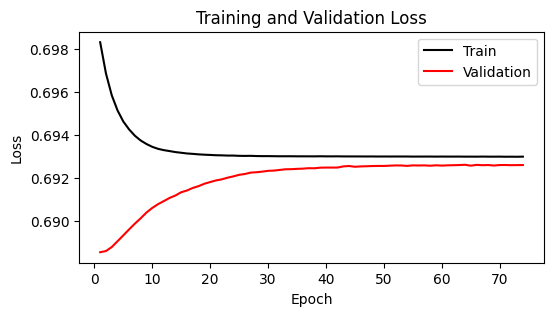

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
META-MODEL SELF TEST:
	Accuracy:	0.55
	Precision:	0.57
	Recall:		0.65


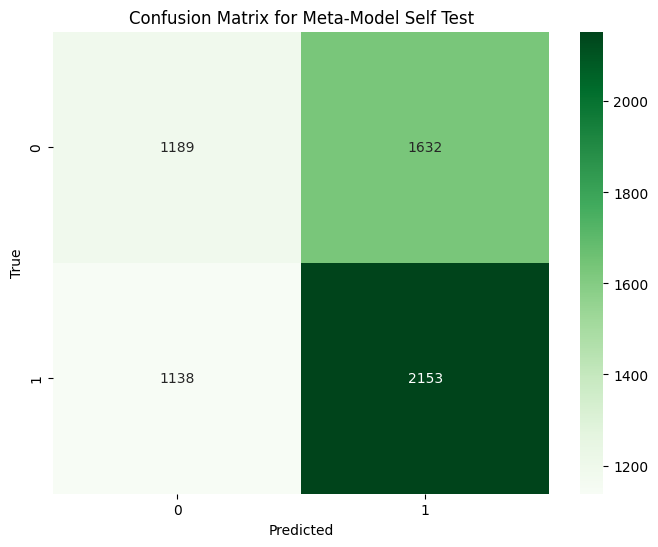

META-MODEL INDEPENDENT TEST:
	Accuracy:	0.58
	Precision:	0.6
	Recall:		0.7


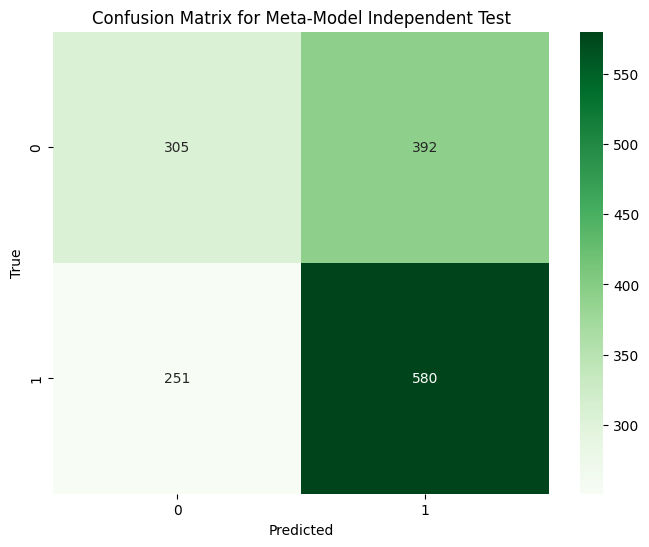

In [5]:
'''NOTE begin training for level-1 model based off of train level-0 model predictions'''

import _Metamodel
from importlib import reload
import _Utility

reload(_Metamodel)

metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models		=	models
	,X_findx	=	X_find_parts
	,X_trans	=	X_trans_parts
	,X_test		=	X_val
	,y_test		=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type =	'NN'
	,use_cls_wt =	True
	,use_mm_params=	True
	,metam_params={
		'optimizer_type':	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.0001
			#,'momentum':0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	75
		,'batch_size'		:	30
		,'rlr_patience'		:	10
		,'architecture'	:	'default_shallow'
		#,'custom_val_data'	:	(X_train, y_train)
		}
)

In [6]:
'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
lstm_format = False
X_test, _, _, __,\
y_test, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,indices	=		0
)

Trying to load CSV file into DataFrame...


loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success...

# of Samples:	21571

# of Features:	519

Target:		tc_2a_60m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training featurespace...Success.
Trying to drop unwanted time-range samples...Success.
	19096 Samples Dropped.

Trying to split X and y into Train/Validation/Independent...Success.
Trying to clean up...Success.
X_train:	(2425, 519).
y_train:	(2425,).
X_val:  	(25, 519).
y_val:  	(25,).
X_ind:  	(25, 519).
y_ind:  	(25,).
Terminating.


944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(30177, 8)
944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step


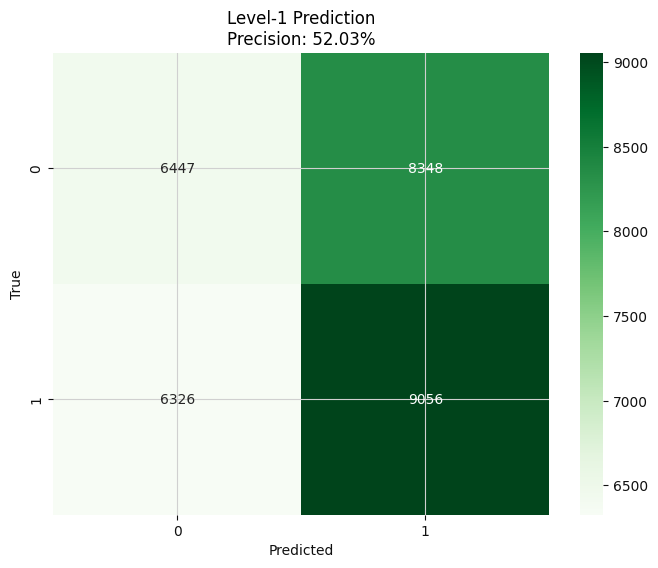

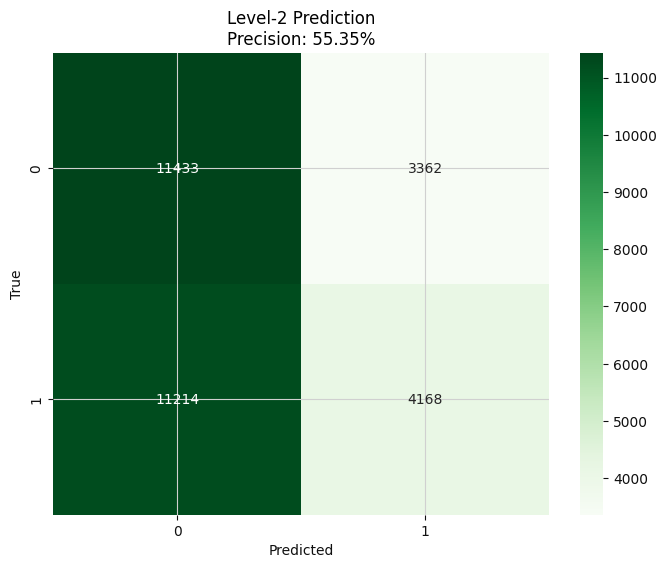

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import _Master_Model
reload(_Master_Model)
reload(_Utility)
from importlib import reload
from sklearn.svm import SVC
from _Utility import get_class_weights

shallow_master = _Master_Model.Master(
	model_depth		=	2
	,all_models 	=	[models, metamodel]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
)

X_blvl2 = X_train
y_blvl2 = y_train

pred_2 = shallow_master.master_predict(X_blvl2)
cm_vals = _Utility.get_cm_values(y_blvl2, pred_2)

_Utility.show_confusion_matrix(y_blvl2,pred_2,title=f'Level-1 Prediction\nPrecision: {round(precision_score(y_blvl2,pred_2)*100, 2)}%')

df = pd.DataFrame(X_blvl2)
df['score'] = cm_vals
df['target'] = y_blvl2
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)
#pd.set_option('display.max_rows',None)
co = df.corr()['target'].drop('target')
#print(co.sort_values())
p = co.nlargest(50).index.tolist()
n = co.nsmallest(50).index.tolist()
feats = p+n

df_pair = pd.DataFrame(X_blvl2)
df_pair = df_pair.iloc[kept_indices].reset_index(drop=True)
df_pair = df_pair.iloc[:, feats]

X_svm = df_pair.values
y_svm = df['target'].values

clf = SVC(kernel='linear',C=1.0,class_weight=_Utility.get_class_weights(df['target'])).fit(X_svm, y_svm)

y_svmpred = pred_2#clf.predict(X_svm)
#'polishing' predictions based on if level-1 predicted (1)
for p in range(len(y_svmpred)):
	if(y_svmpred[p] == 1):
		y_svmpred[p] = clf.predict(X[p,feats].reshape(1, -1))

#_Utility.show_confusion_matrix(df['target'],y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_svm, y_svmpred)*100, 2)}%')
_Utility.show_confusion_matrix(y_blvl2,y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_blvl2, y_svmpred)*100, 2)}%')


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


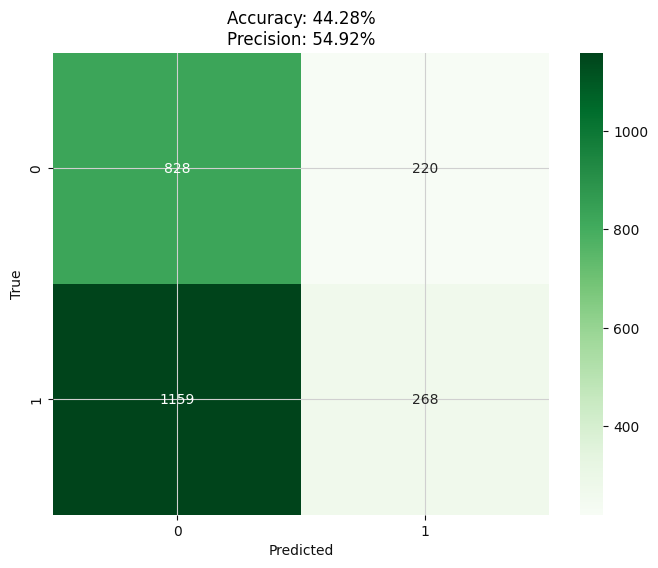

In [33]:
reload(_Master_Model)
reload(_Utility)
deep_master = _Master_Model.Master(
	model_depth		=	3
	,all_models 	=	[models, metamodel.model, clf]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
    ,lvl2_formatters=	[feats]
)

y_3pred = deep_master.master_predict(X_test)

_Utility.show_confusion_matrix(y_test, y_3pred, title=f'Accuracy: {_Utility.get_accuracy(y_test, y_3pred)}\nPrecision: {_Utility.get_precision(y_test, y_3pred)}')

In [35]:
import _Master_Model
from importlib import reload
reload(_Master_Model)
#deep_master = _Master_Model.Master(model_depth=3)
#deep_master.load_model('pre63p2-645-800')
deep_master.save_model()

Folder tree generated successfully.
PATH: tmp_model/level_0/model_0_0_0
keras saving complete
PATH: tmp_model/level_0/model_1_0_0
keras saving complete
PATH: tmp_model/level_0/model_2_0_0
keras saving complete
PATH: tmp_model/level_0/model_3_0_0
keras saving complete
PATH: tmp_model/level_0/model_4_0_0
keras saving complete
PATH: tmp_model/level_0/model_5_0_0
keras saving complete
PATH: tmp_model/level_0/model_6_0_0
keras saving complete
PATH: tmp_model/level_0/model_7_0_0
keras saving complete
helloooo


In [36]:
import _Time_Ensemble
import _Master_Model
import joblib
import _Utility

'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
reload(_Master_Model)
reload(_Time_Ensemble)
lstm_format = False
X_te, _, _, __,\
y_te, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

chronos_array = _Time_Ensemble.chronos_predict(X_te,                       
['pre63p2-645-800','models/m55','models/m60','models/m50','models/60_811_svm100'])


loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
	19096 Samples Dropped.

Chronos: Predicting on Model #1 (pre63p2-645-800)
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Chronos: Predicting on Model #2 (models/m55)
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Chronos: Predicting on Model #3 (models/m60)


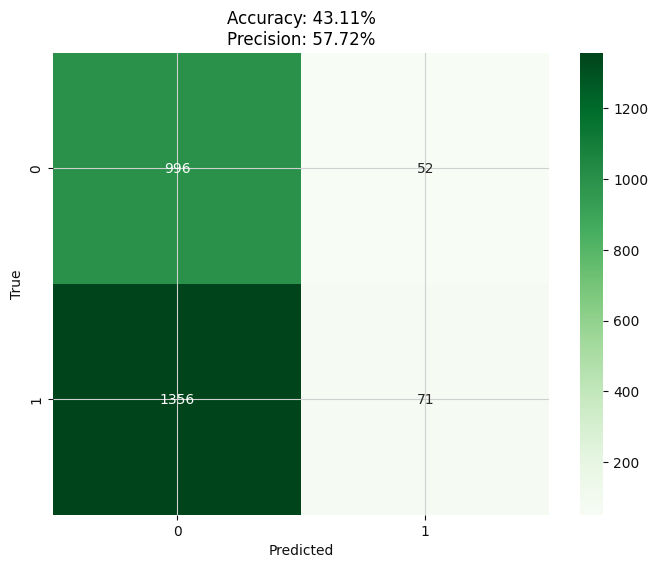

In [ ]:
reload(_Utility)
reload(_Time_Ensemble)
t_pred	=	_Time_Ensemble.chronos_fusion(master_predictions=chronos_array, fusion_method='mv',vote_var=3)
_Utility.show_confusion_matrix(y_te, t_pred, title=f'Accuracy: {_Utility.get_accuracy(y_te, t_pred)}\nPrecision: {_Utility.get_precision(y_te, t_pred)}')

In [ ]:
#reload(_Utility)
#reload(_Time_Ensemble)
#vals = _Utility.graph_range(_Time_Ensemble.chronos_fusion, kw='vote_var', kw_range=range(0,5), show_graph=False, master_predictions=chronos_array,fusion_method='mv')
#scores = [precision_score(y_te, vals[i]) for i in range(0,5)]
#_Utility.plot_standard_line(scores, range(0,5))

In [ ]:
from _Utility import get_name_from_fss
get_name_from_fss(fss=feature_subsets,index=138)

'stchK60_spx'

loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
	19096 Samples Dropped.



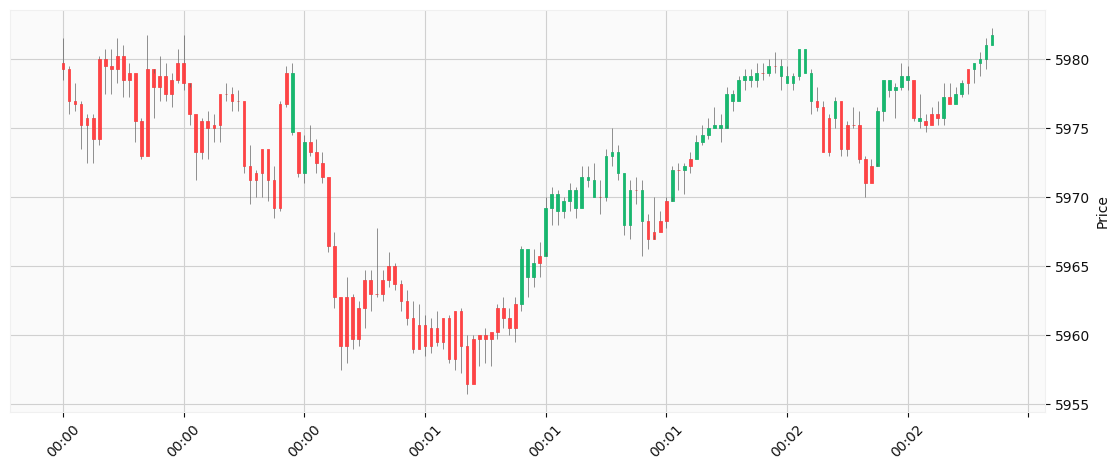

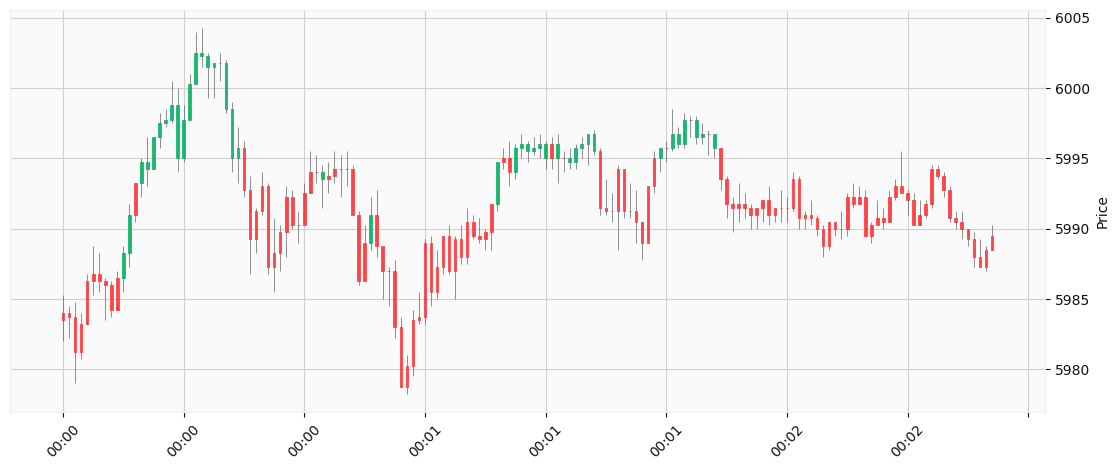

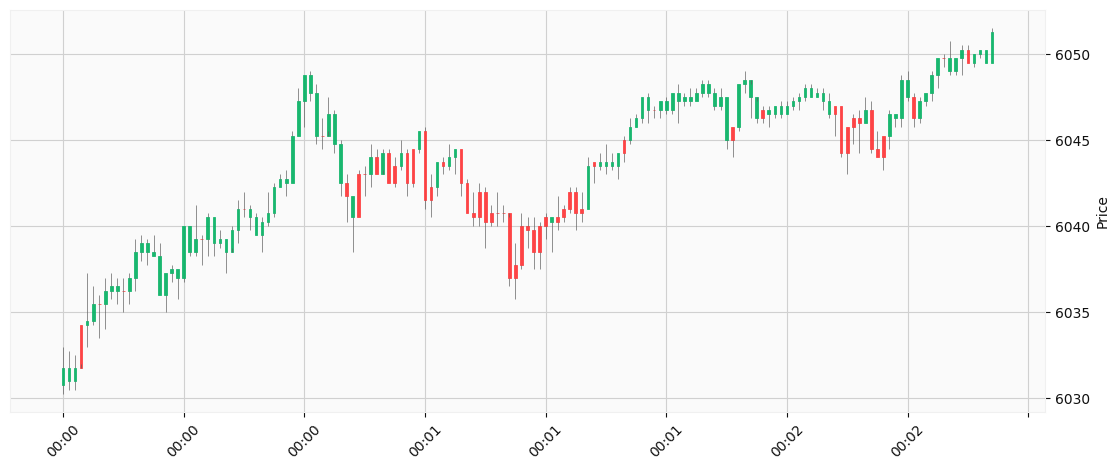

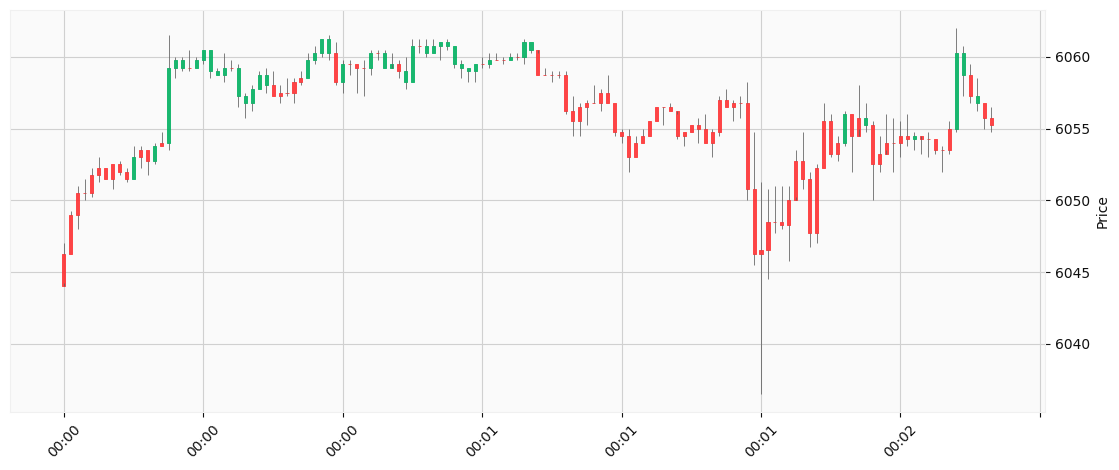

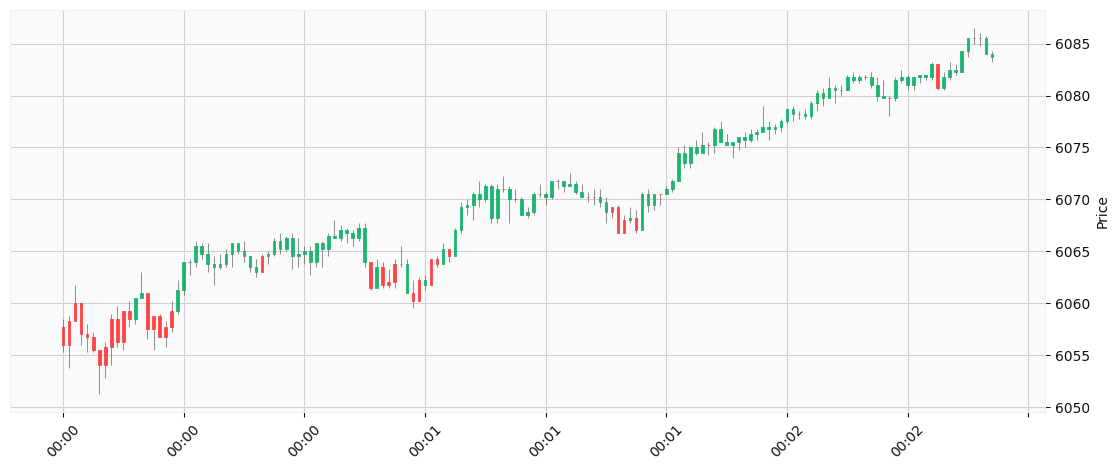

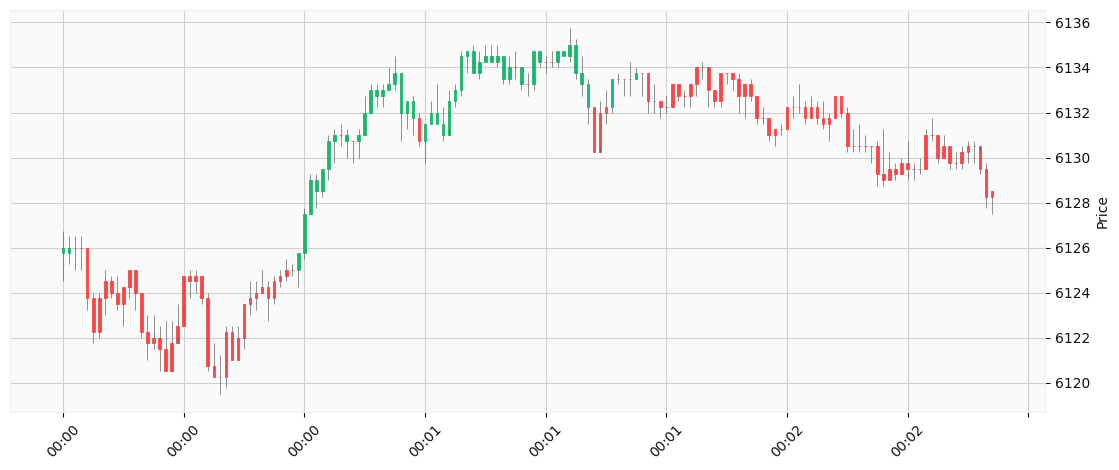

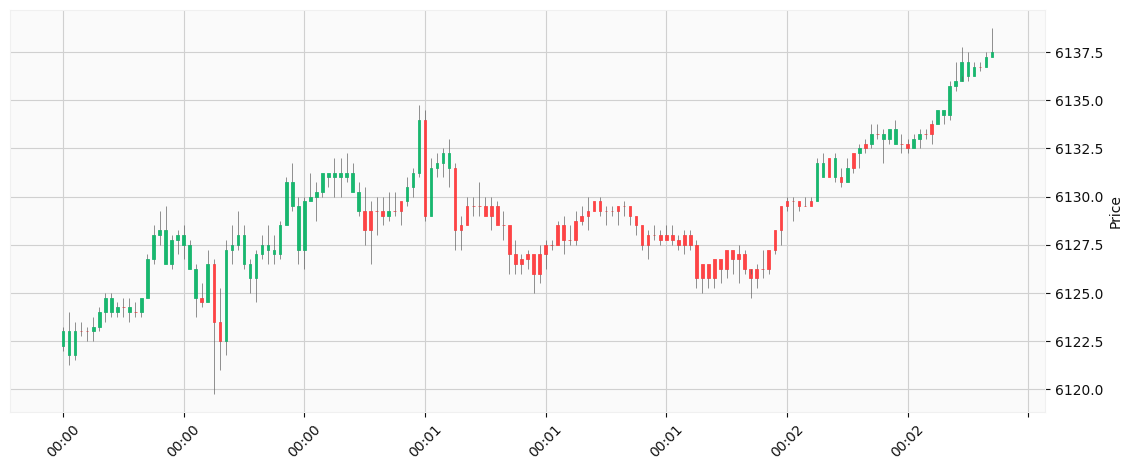

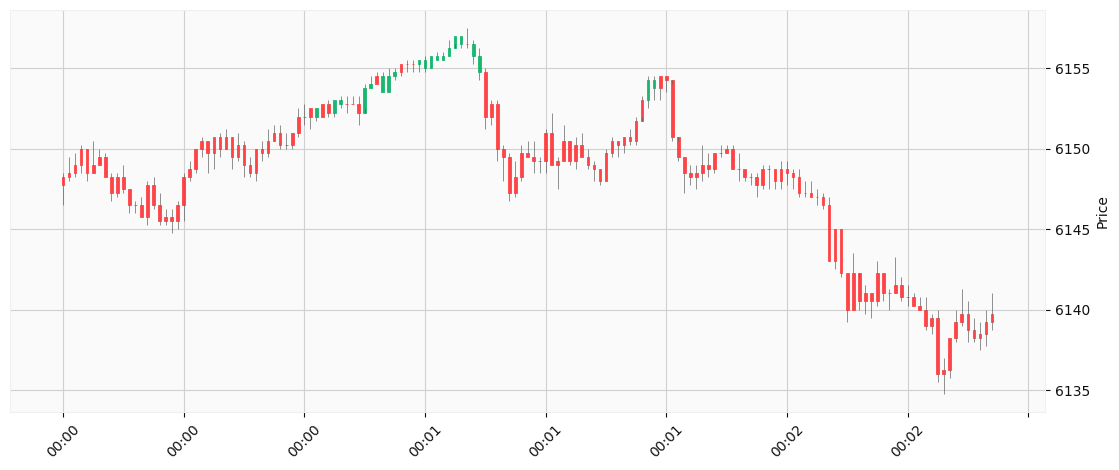

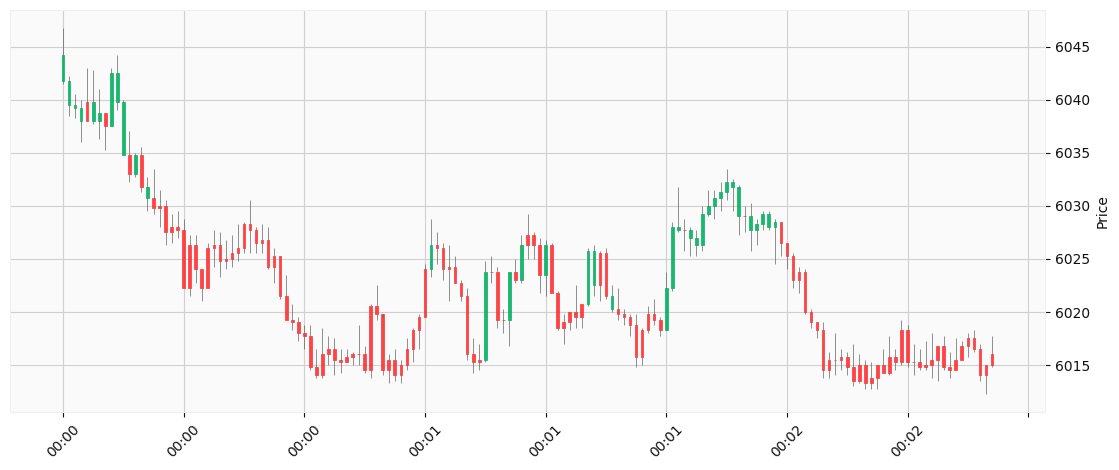

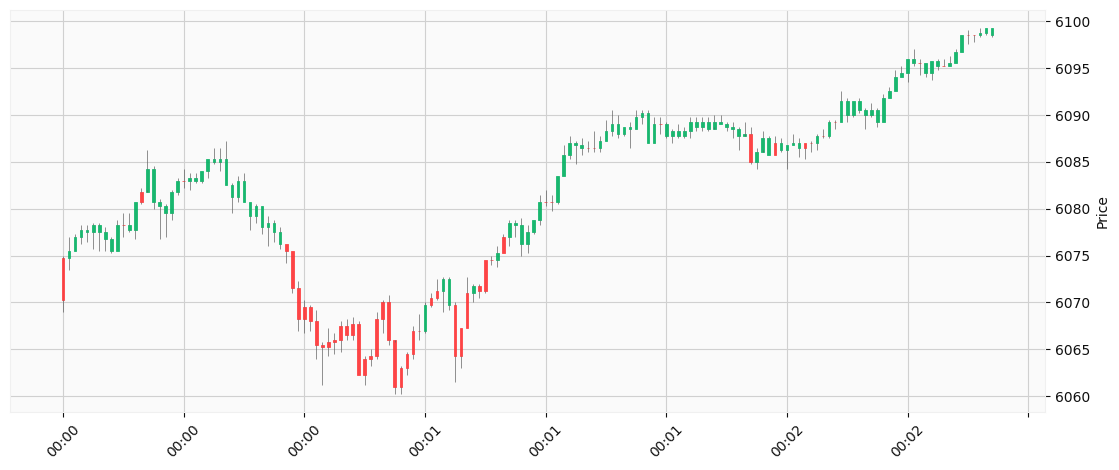

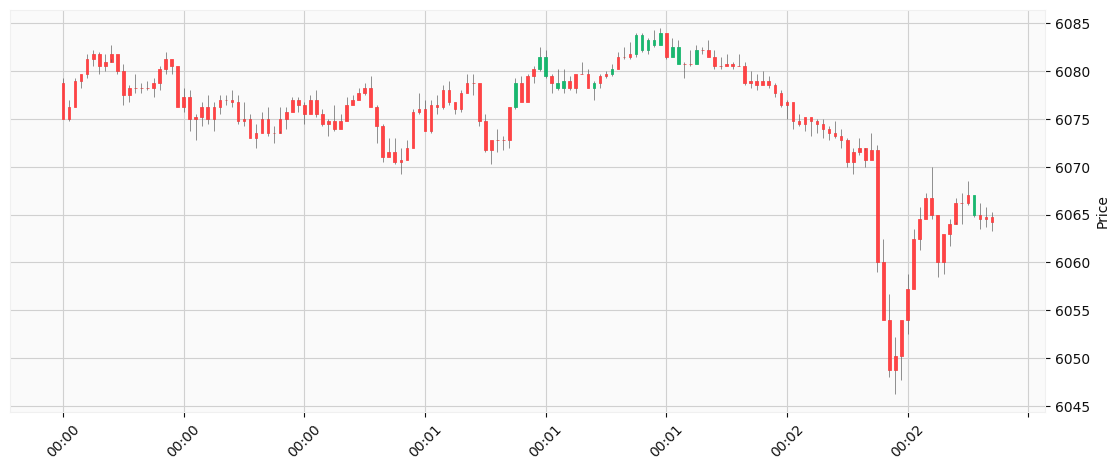

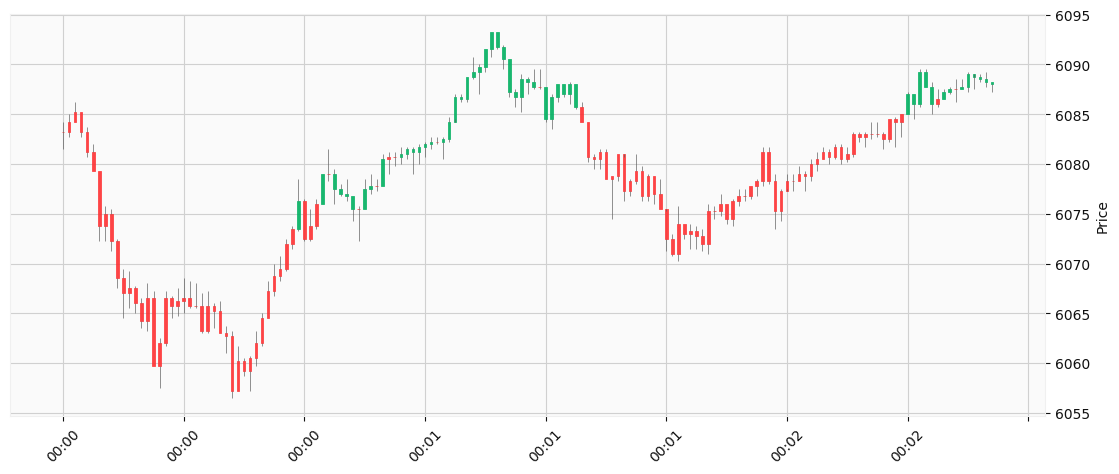

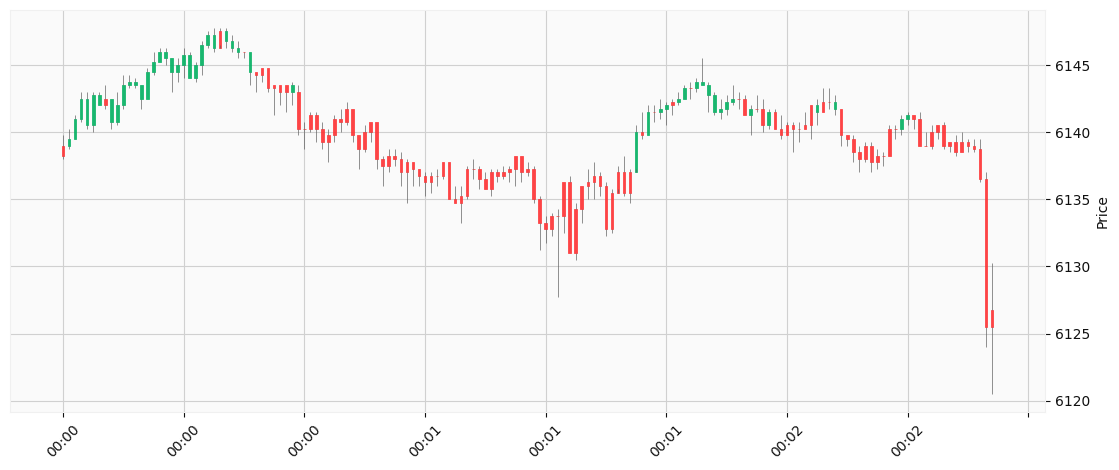

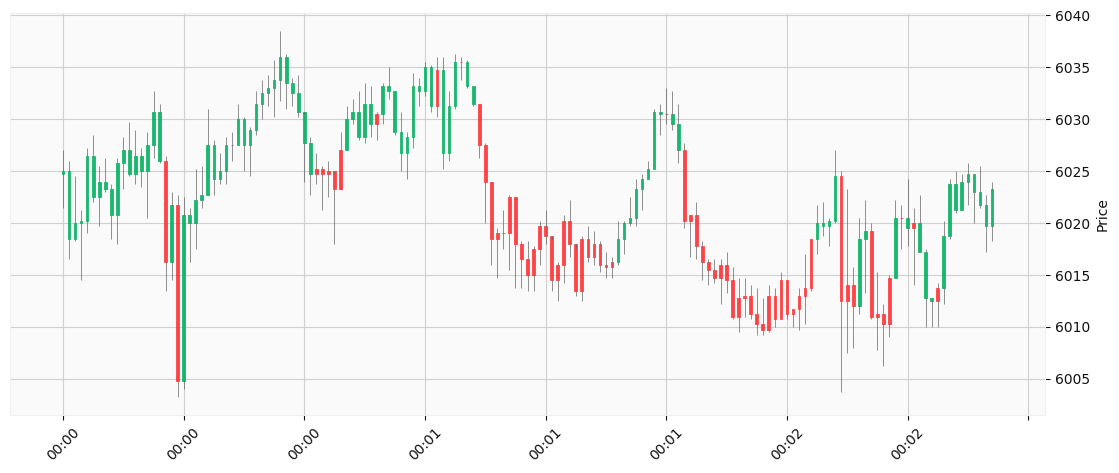

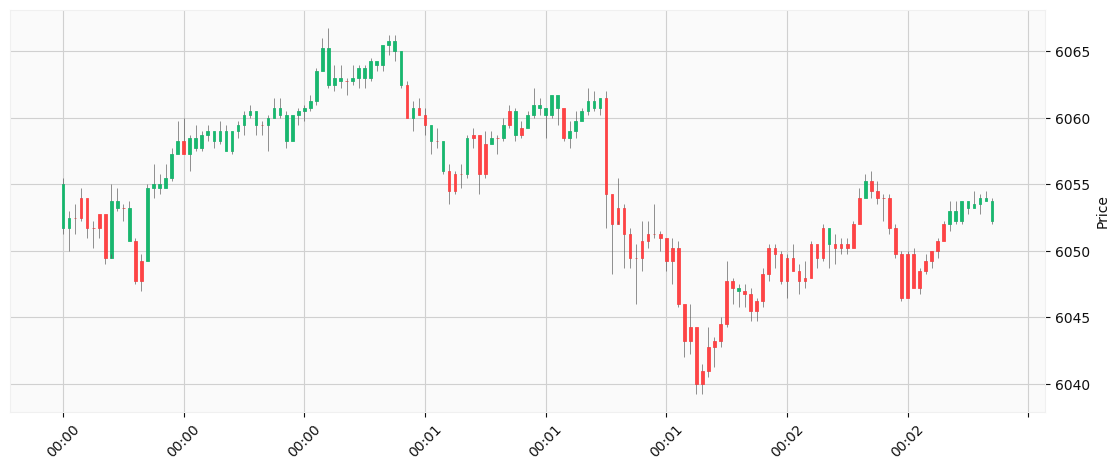

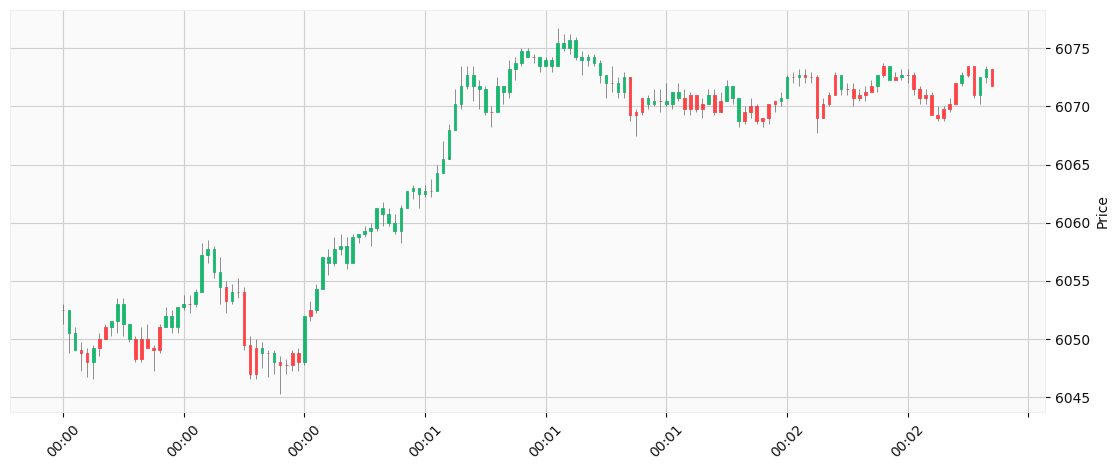

In [43]:
#showing chart of predictions
X_raw, _, _, __,\
y_raw, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'None'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

reload(_Utility)
_Utility.show_predictions_chart(X_raw=X_raw,predictions=t_pred, t_start=645, t_end=800
                                #, add_chart=[128,132]
                                , fss=feature_subsets)